In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("src")

In [3]:
%matplotlib inline

from infomap              import Infomap
from pathlib              import Path
from sklearn.metrics      import adjusted_mutual_info_score
from torch_geometric.data import Data
from training             import Neuromap, DMoN, MinCut, Ortho, DiffPool, NOCD
from typing               import List
from util                 import *

import json
import matplotlib.pyplot as plt
import networkx          as nx
import numpy             as np
import seaborn           as sb
import torch

In [4]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [5]:
palette = sb.color_palette("colorblind")
sb.color_palette(palette)

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [7]:
undirected_LFR = Path("./binary_networks/benchmark")
if not undirected_LFR.exists():
    print("Binary for generating undirected LFR networks not found.")

directed_LFR = Path("./directed_networks/benchmark")
if not directed_LFR.exists():
    print("Binary for generating directed   LFR networks not found.")

Binary for generating undirected LFR networks not found.
Binary for generating directed   LFR networks not found.


In [8]:
def run(params, method : str = "neuromap", num_networks : int = 1, num_trials : int = 1, epochs : int = 10000, patience : int = 100, lrs : List[float] = [0.01], directed : bool = False, mode = "mean"):
    if not directed:
        results_folder = Path("./results/lfr-binary/")
        mkNetwork      = mkBinary
    else:
        results_folder = Path("./results/lfr-directed/")
        mkNetwork      = mkDirected

    results = dict()

    for param in params:
        N    = param["N"]
        tau1 = 2
        tau2 = 1
        results[N] = dict()
        for k in param["k"]:
            results[N][k] = dict()
            for maxk in param["maxk"]:
                results[N][k][maxk] = dict()
                for mu in param["mu"]:

                    results[N][k][maxk][mu] = dict()
                    results[N][k][maxk][mu]["true"] = dict(ami = list(), m = list(), codelength = list())
                    for (model, _) in param["models"]:
                        results[N][k][maxk][mu][model] = dict(ami = list(), m = list(), codelength = list())

                    print(f"\nN = {N}, k = {k}, maxk = {maxk}, mu = {mu:.2f} ", end = "")
                    for running_number in range(num_networks):
                        print(".", end = "")

                        G, y_true = mkNetwork(N = N, k = k, maxk = maxk, tau1 = tau1, tau2 = tau2, mu = mu, running_number = running_number)
                        data = to_dataset(G = G, y_true = y_true)

                        results[N][k][maxk][mu]["true"]["m"].append(len(set(y_true)))
                        results[N][k][maxk][mu]["true"]["codelength"].append(get_codelength(G = G, y = y_true, directed = directed))

                        for (model, config) in param["models"]:
                            if method == "neuromap":
                                out = results_folder.joinpath(f"{model}-N-{N}-k-{k:.2f}-mu-{mu:.2f}-t1-{tau1:.2f}-t2-{tau2:.2f}-maxk-{maxk}.{running_number:03}.json")
                            else:
                                out = results_folder.joinpath(f"{method}-{model}-N-{N}-k-{k:.2f}-mu-{mu:.2f}-t1-{tau1:.2f}-t2-{tau2:.2f}-maxk-{maxk}.{running_number:03}.json")

                            if out.exists():
                                with open(out, "r") as fh:
                                    res = json.load(fh)
                            else:
                                res = dict()


                            if model == "Infomap" and method == "neuromap":
                                np.random.seed(47)
                                seeds = np.random.randint(0, 1000000, size = num_trials)
                                for trial, seed in enumerate(seeds, start = 1):
                                    if str(trial) not in res:
                                        im = Infomap(silent = True, two_level = True, num_trials = 1, seed = seed)
                                        im.add_networkx_graph(G)
                                        im.run()
                                        modules = dict(im.modules)

                                        y_pred = [modules[u] for u in sorted(G.nodes)]
                                        ami    = adjusted_mutual_info_score(y_true, y_pred)

                                        res[str(trial)] = dict(loss = im.codelength, y_pred = y_pred, ami = ami, m = len(set(y_pred)))

                                        with open(out, "w") as fh:
                                            json.dump(res, fh)

                            # (G)NN models
                            else:
                                for trial in range(1, num_trials + 1):
                                    if str(trial) not in res:
                                        if method == "neuromap":
                                            clusterer = Neuromap(use_model = config["use_model"], in_channels = config["in_channels"], hidden_channels = config["hidden_channels"], out_channels = config["out_channels"], num_layers = config["num_layers"], dropout = config["dropout"])
                                        
                                        elif method == "dmon":
                                            clusterer = DMoN(use_model = config["use_model"], in_channels = config["in_channels"], hidden_channels = config["hidden_channels"], out_channels = config["out_channels"], num_layers = config["num_layers"], dropout = config["dropout"])
                                        
                                        elif method == "nocd":
                                            clusterer = NOCD(use_model = config["use_model"], in_channels = config["in_channels"], hidden_channels = config["hidden_channels"], out_channels = config["out_channels"], num_layers = config["num_layers"], dropout = config["dropout"])
                                        
                                        elif method == "ortho":
                                            clusterer = Ortho(use_model = config["use_model"], in_channels = config["in_channels"], hidden_channels = config["hidden_channels"], out_channels = config["out_channels"], num_layers = config["num_layers"], dropout = config["dropout"])
                                        
                                        elif method == "mincut":
                                            clusterer = MinCut(use_model = config["use_model"], in_channels = config["in_channels"], hidden_channels = config["hidden_channels"], out_channels = config["out_channels"], num_layers = config["num_layers"], dropout = config["dropout"])
                                        
                                        elif method == "diffpool":
                                            clusterer = DiffPool(use_model = config["use_model"], in_channels = config["in_channels"], hidden_channels = config["hidden_channels"], out_channels = config["out_channels"], num_layers = config["num_layers"], dropout = config["dropout"])

                                        l, s   = clusterer.fit(data = data, epochs = epochs, patience = patience, lrs = config["lrs"], num_trials = 1, verbose = False)
                                        y_pred = get_hard_clusters(s)

                                        ami = adjusted_mutual_info_score(y_true, y_pred)
                                        m   = len(set(y_pred))

                                        res[str(trial)] = dict(loss = l, y_pred = y_pred, ami = ami, m = m)

                                        with open(out, "w") as fh:
                                            json.dump(res, fh)

                            if mode == "best":
                                best_result = min(res.values(), key = lambda r: r["loss"])
                                y_pred      = best_result["y_pred"]

                                results[N][k][maxk][mu][model]["ami"].append(best_result["ami"])
                                results[N][k][maxk][mu][model]["m"].append(best_result["m"])
                                if method == "neuromap":
                                    results[N][k][maxk][mu][model]["codelength"].append(get_codelength(G = G, y = y_pred, directed = directed))

                            elif mode in ["mean", "avg"]:
                                ami = np.mean([r["ami"] for r in res.values()])
                                if not np.isnan(ami):
                                    results[N][k][maxk][mu][model]["ami"].append(ami)
                                
                                m = np.mean([r["m"] for r in res.values()])
                                if not np.isnan(m):
                                    results[N][k][maxk][mu][model]["m"].append(m)

                                if method == "neuromap":
                                    results[N][k][maxk][mu][model]["codelength"].append(np.mean([get_codelength(G = G, y = r["y_pred"], directed = directed) for r in res.values()]))

    return results

Parameters for LFR networks

In [9]:
Path("./data/lfr-binary").mkdir(parents = True, exist_ok = True)
Path("./data/lfr-directed").mkdir(parents = True, exist_ok = True)
Path("./results/lfr-binary").mkdir(parents = True, exist_ok = True)
Path("./results/lfr-directed").mkdir(parents = True, exist_ok = True)

In [10]:
params = [ dict( N =  1000
               , k = [round(np.log(1000)), round(2*np.log(1000))]
               , maxk = [round(2*np.sqrt(1000))]
               , mu = [0.1 * i for i in range(1,9)]
               , models = [ ("Infomap", dict())
                          , ("Linear", dict(use_model = "lin",  in_channels = 1000, hidden_channels = 1000, out_channels = 1000, num_layers = 1, dropout = 0.5, lrs = [1e-1]))
                          , ("MLP",    dict(use_model = "mlp",  in_channels = 1000, hidden_channels = 1000, out_channels = 1000, num_layers = 2, dropout = 0.5, lrs = [1e-2]))
                          , ("GIN",    dict(use_model = "gin",  in_channels = 1000, hidden_channels = 1000, out_channels = 1000, num_layers = 2, dropout = 0.5, lrs = [1e-3]))
                          , ("GCN",    dict(use_model = "gcn",  in_channels = 1000, hidden_channels = 1000, out_channels = 1000, num_layers = 2, dropout = 0.5, lrs = [1e-3]))
                          , ("SAGE",   dict(use_model = "sage", in_channels = 1000, hidden_channels = 1000, out_channels = 1000, num_layers = 2, dropout = 0.5, lrs = [1e-3]))
                          ]
               )
]

results_undirected = run(params = params, num_networks = 10, num_trials = 10, epochs = 10000, patience = 100, directed = False)
results_directed   = run(params = params, num_networks = 10, num_trials = 10, epochs = 10000, patience = 100, directed = True)


N = 1000, k = 7, maxk = 63, mu = 0.10 ..........
N = 1000, k = 7, maxk = 63, mu = 0.20 ..........
N = 1000, k = 7, maxk = 63, mu = 0.30 ..........
N = 1000, k = 7, maxk = 63, mu = 0.40 ..........
N = 1000, k = 7, maxk = 63, mu = 0.50 ..........
N = 1000, k = 7, maxk = 63, mu = 0.60 ..........
N = 1000, k = 7, maxk = 63, mu = 0.70 ..........
N = 1000, k = 7, maxk = 63, mu = 0.80 ..........
N = 1000, k = 14, maxk = 63, mu = 0.10 ..........
N = 1000, k = 14, maxk = 63, mu = 0.20 ..........
N = 1000, k = 14, maxk = 63, mu = 0.30 ..........
N = 1000, k = 14, maxk = 63, mu = 0.40 ..........
N = 1000, k = 14, maxk = 63, mu = 0.50 ..........
N = 1000, k = 14, maxk = 63, mu = 0.60 ..........
N = 1000, k = 14, maxk = 63, mu = 0.70 ..........
N = 1000, k = 14, maxk = 63, mu = 0.80 ..........
N = 1000, k = 7, maxk = 63, mu = 0.10 ..........
N = 1000, k = 7, maxk = 63, mu = 0.20 ..........
N = 1000, k = 7, maxk = 63, mu = 0.30 ..........
N = 1000, k = 7, maxk = 63, mu = 0.40 ..........
N = 1000, k

PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `results-lfr-crop.pdf'.


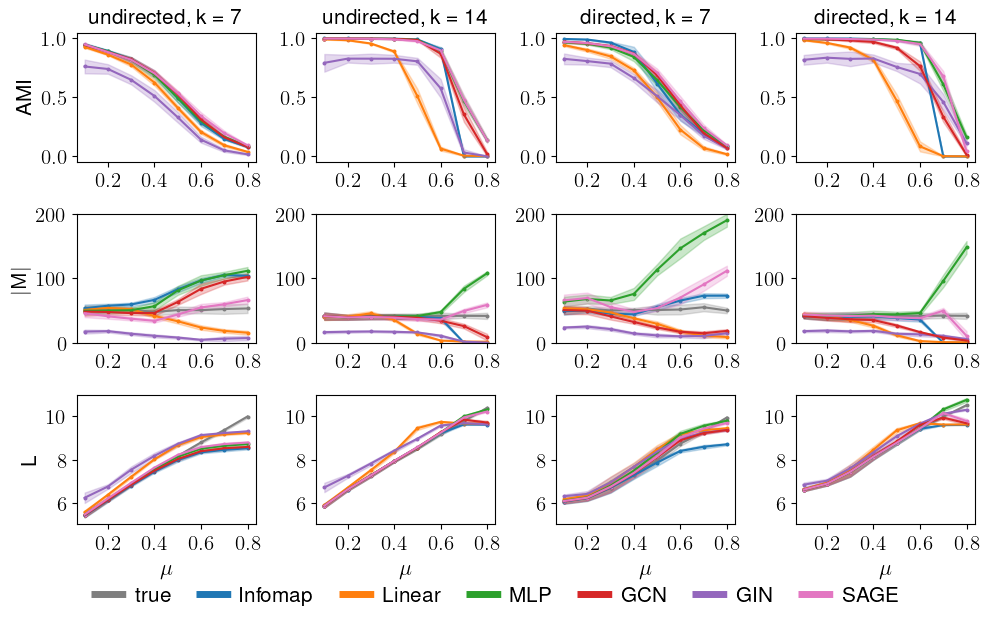

In [11]:
fig, axss = plt.subplots(3, 4, figsize = (10,6))

model_colours = { "true"    : sb.color_palette()[7]
                , "Infomap" : sb.color_palette()[0]
                , "Linear"  : sb.color_palette()[1]
                , "MLP"     : sb.color_palette()[2]
                , "GCN"     : sb.color_palette()[3]
                , "GIN"     : sb.color_palette()[4]
                , "SAGE"    : sb.color_palette()[6]
                }

# undirected
for col, (N, k, kmax) in enumerate([(1000, 7, 63), (1000, 14, 63)]):
    r = results_undirected[N][k][kmax]
    xs = r.keys()

    for row, measure in enumerate(["m", "codelength"], start = 1):
        yss   = [vs["true"][measure] for vs in r.values()]
        means = np.array([np.average(ys) for ys in yss])
        errors = np.array([np.std(ys) for ys in yss])
        axss[row][col].fill_between(xs, means + errors, means - errors, alpha = 0.25, color = model_colours["true"])
        axss[row][col].plot(xs, means, linestyle = "-", color = model_colours["true"])
        axss[row][col].scatter(xs, means, marker = ".", color = model_colours["true"], s = 14)

    for model,_ in params[0]["models"]:
        for row, measure in enumerate(["ami", "m", "codelength"]):
            yss   = [vs[model][measure] for vs in r.values()]
            means = np.array([np.average(ys) for ys in yss])
            errors = np.array([np.std(ys) for ys in yss])
            axss[row][col].fill_between(xs, means + errors, means - errors, alpha = 0.25, color = model_colours[model])
            axss[row][col].plot(xs, means, linestyle = "-", color = model_colours[model])
            axss[row][col].scatter(xs, means, marker = ".", color = model_colours[model], s = 14)

# directed
for col, (N, k, kmax) in enumerate([(1000, 7, 63), (1000, 14, 63)], start = 2):
    r = results_directed[N][k][kmax]
    xs = r.keys()

    for row, measure in enumerate(["m", "codelength"], start = 1):
        yss   = [vs["true"][measure] for vs in r.values()]
        means = np.array([np.average(ys) for ys in yss])
        errors = np.array([np.std(ys) for ys in yss])
        axss[row][col].fill_between(xs, means + errors, means - errors, alpha = 0.25, color = model_colours["true"])
        axss[row][col].plot(xs, means, linestyle = "-", color = model_colours["true"])
        axss[row][col].scatter(xs, means, marker = ".", color = model_colours["true"], s = 14)

    for model,_ in params[0]["models"]:
        for row, measure in enumerate(["ami", "m", "codelength"]):
            yss   = [vs[model][measure] for vs in r.values()]
            means = np.array([np.average(ys) for ys in yss])
            errors = np.array([np.std(ys) for ys in yss])
            axss[row][col].fill_between(xs, means + errors, means - errors, alpha = 0.25, color = model_colours[model])
            axss[row][col].plot(xs, means, linestyle = "-", color = model_colours[model])
            axss[row][col].scatter(xs, means, marker = ".", color = model_colours[model], s = 14)

axss[0][0].set_ylabel("AMI", fontsize = 15)
axss[1][0].set_ylabel("$|\mathsf{M}|$", fontsize = 15)
axss[2][0].set_ylabel("L", fontsize = 15)

axss[0][0].set_title("undirected, k = 7", fontsize = 15)
axss[0][1].set_title("undirected, k = 14", fontsize = 15)
axss[0][2].set_title("directed, k = 7", fontsize = 15)
axss[0][3].set_title("directed, k = 14", fontsize = 15)


for ax in axss[0]:
    ax.set_ylim(-0.05,1.05)

for ax in axss[1]:
    ax.set_ylim(0,200)

for ax in axss[-1]:
    ax.set_ylim(5,11)
    ax.set_xlabel("$\mu$", fontsize = 16)

for axs in axss:
    for ax in axs:
        ax.tick_params(axis = "both", labelsize = 15)
        ax.set_xticks([0.2,0.4,0.6,0.8])

for model in ["true", "Infomap", "Linear", "MLP", "GCN", "GIN", "SAGE"]:
    plt.plot([], [], linestyle = (0, (5, 10)), label = model, color = model_colours[model], linewidth = 5)

fig.legend(frameon = False, ncol = 7, columnspacing = 1.2, handletextpad = 0.1, loc = "lower center", bbox_to_anchor = (0.5, -0.05), fontsize = 15)
fig.tight_layout()
plt.savefig("results-lfr.pdf", transparent = True, bbox_inches = "tight")
!pdfcrop results-lfr.pdf
!mv results-lfr-crop.pdf results-lfr.pdf

In [12]:
params = [ dict( N =  1000
               , k = [round(np.log(1000)), round(2*np.log(1000))]
               , maxk = [round(2*np.sqrt(1000))]
               , mu = [0.1 * i for i in range(1,9)]
               , models = [ ("Linear", dict(use_model = "lin",  in_channels = 1000, hidden_channels = 1000, out_channels = 1000, num_layers = 1, dropout = 0.5, lrs = [1e-1]))
                          , ("MLP",    dict(use_model = "mlp",  in_channels = 1000, hidden_channels = 1000, out_channels = 1000, num_layers = 2, dropout = 0.5, lrs = [1e-2]))
                          , ("GIN",    dict(use_model = "gin",  in_channels = 1000, hidden_channels = 1000, out_channels = 1000, num_layers = 2, dropout = 0.5, lrs = [1e-3]))
                          , ("GCN",    dict(use_model = "gcn",  in_channels = 1000, hidden_channels = 1000, out_channels = 1000, num_layers = 2, dropout = 0.5, lrs = [1e-3]))
                          , ("SAGE",   dict(use_model = "sage", in_channels = 1000, hidden_channels = 1000, out_channels = 1000, num_layers = 2, dropout = 0.5, lrs = [1e-3]))
                          ]
               )
         ]

print("NOCD", end = "")
nocd_results_undirected = run(params = params, method = "nocd", num_networks = 10, num_trials = 10, epochs = 10000, patience = 1000, directed = False)
nocd_results_directed   = run(params = params, method = "nocd", num_networks = 10, num_trials = 10, epochs = 10000, patience = 1000, directed = True)

print("\nDMoN", end = "")
dmon_results_undirected = run(params = params, method = "dmon", num_networks = 10, num_trials = 10, epochs = 10000, patience = 1000, directed = False)
dmon_results_directed   = run(params = params, method = "dmon", num_networks = 10, num_trials = 10, epochs = 10000, patience = 1000, directed = True)

print("\nMinCut", end = "")
mincut_results_undirected = run(params = params, method = "mincut", num_networks = 10, num_trials = 10, epochs = 10000, patience = 1000, directed = False)
mincut_results_directed   = run(params = params, method = "mincut", num_networks = 10, num_trials = 10, epochs = 10000, patience = 1000, directed = True)

print("\nOrtho", end = "")
ortho_results_undirected = run(params = params, method = "ortho", num_networks = 10, num_trials = 10, epochs = 10000, patience = 1000, directed = False)
ortho_results_directed   = run(params = params, method = "ortho", num_networks = 10, num_trials = 10, epochs = 10000, patience = 1000, directed = True)

print("\nDiffPool", end = "")
diffpool_results_undirected = run(params = params, method = "diffpool", num_networks = 10, num_trials = 10, epochs = 10000, patience = 1000, directed = False)
diffpool_results_directed   = run(params = params, method = "diffpool", num_networks = 10, num_trials = 10, epochs = 10000, patience = 1000, directed = True)

NOCD
N = 1000, k = 7, maxk = 63, mu = 0.10 ..........
N = 1000, k = 7, maxk = 63, mu = 0.20 ..........
N = 1000, k = 7, maxk = 63, mu = 0.30 ..........
N = 1000, k = 7, maxk = 63, mu = 0.40 ..........
N = 1000, k = 7, maxk = 63, mu = 0.50 ..........
N = 1000, k = 7, maxk = 63, mu = 0.60 ..........
N = 1000, k = 7, maxk = 63, mu = 0.70 ..........
N = 1000, k = 7, maxk = 63, mu = 0.80 ..........
N = 1000, k = 14, maxk = 63, mu = 0.10 ..........
N = 1000, k = 14, maxk = 63, mu = 0.20 ..........
N = 1000, k = 14, maxk = 63, mu = 0.30 ..........
N = 1000, k = 14, maxk = 63, mu = 0.40 ..........
N = 1000, k = 14, maxk = 63, mu = 0.50 ..........
N = 1000, k = 14, maxk = 63, mu = 0.60 ..........
N = 1000, k = 14, maxk = 63, mu = 0.70 ..........
N = 1000, k = 14, maxk = 63, mu = 0.80 ..........
N = 1000, k = 7, maxk = 63, mu = 0.10 ..........
N = 1000, k = 7, maxk = 63, mu = 0.20 ..........
N = 1000, k = 7, maxk = 63, mu = 0.30 ..........
N = 1000, k = 7, maxk = 63, mu = 0.40 ..........
N = 100

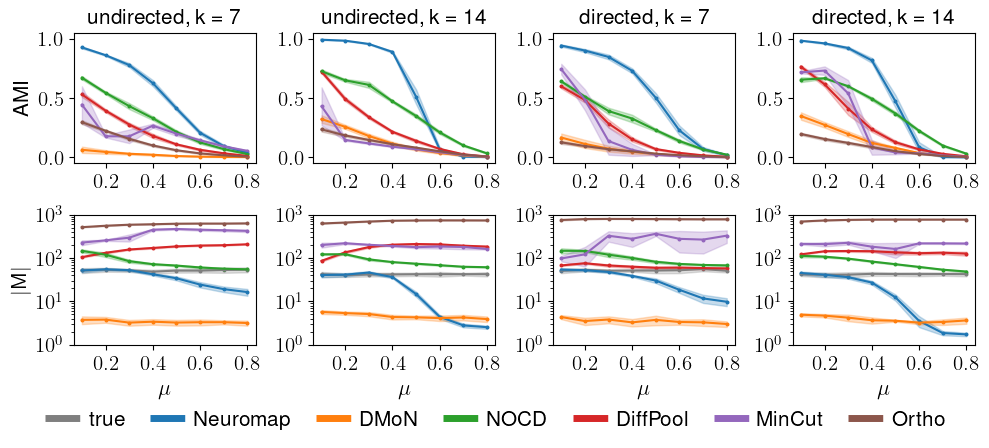

PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `results-loss-functions-Linear-crop.pdf'.


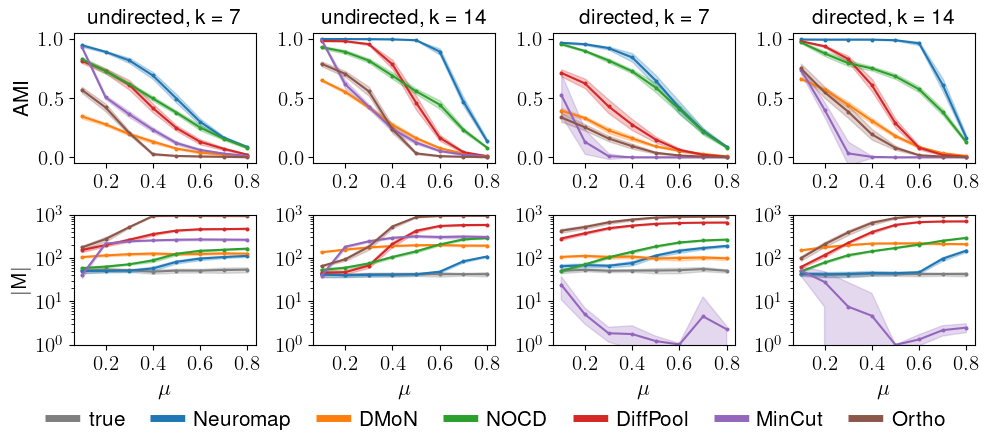

PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `results-loss-functions-MLP-crop.pdf'.


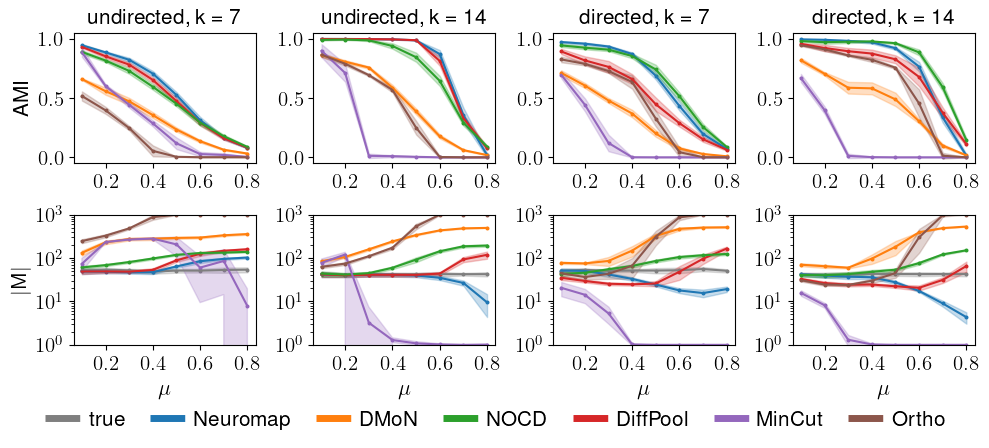

PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `results-loss-functions-GCN-crop.pdf'.


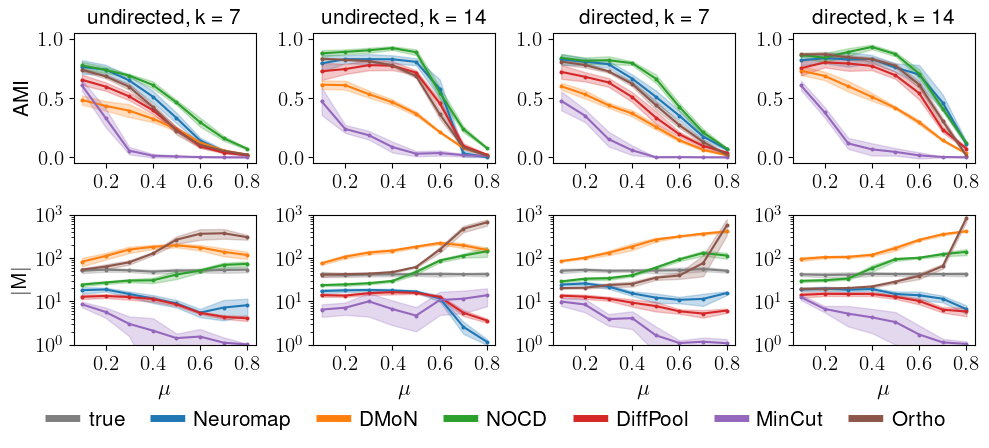

PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `results-loss-functions-GIN-crop.pdf'.


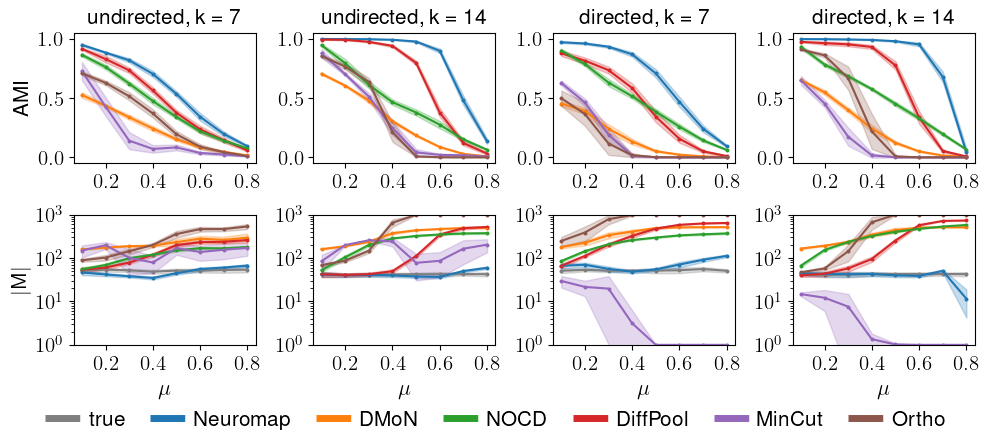

PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `results-loss-functions-SAGE-crop.pdf'.


In [13]:
model_colours = { "true"     : sb.color_palette()[7]
                , "Neuromap" : sb.color_palette()[0]
                , "NOCD"     : sb.color_palette()[2]
                , "DiffPool" : sb.color_palette()[3]
                , "MinCut"   : sb.color_palette()[4]
                , "Ortho"    : sb.color_palette()[5]
                , "DMoN"     : sb.color_palette()[1]
                }

losses = [ ("Neuromap", results_undirected, results_directed)
         , ("DMoN", dmon_results_undirected, dmon_results_directed)
         , ("DiffPool", diffpool_results_undirected, diffpool_results_directed)
         , ("NOCD", nocd_results_undirected, nocd_results_directed)
         , ("MinCut", mincut_results_undirected, mincut_results_directed)
         , ("Ortho", ortho_results_undirected, ortho_results_directed)
         ]

for arch in ["Linear", "MLP", "GCN", "GIN", "SAGE"]:
    fig, axss = plt.subplots(2, 4, figsize = (10,4.2))

    # undirected
    for col, (N, k, kmax) in enumerate([(1000, 7, 63), (1000, 14, 63)]):
        r = results_undirected[N][k][kmax]
        xs = r.keys()

        for row, measure in enumerate(["m"], start = 1):
            yss   = [vs["true"][measure] for vs in r.values()]
            means = np.array([np.average([y for y in ys if not np.isnan(y)]) for ys in yss])
            errors = np.array([np.std([y for y in ys if not np.isnan(y)]) for ys in yss])
            axss[row][col].fill_between(xs, means + errors, means - errors, alpha = 0.25, color = model_colours["true"])
            axss[row][col].plot(xs, means, linestyle = "-", color = model_colours["true"])
            axss[row][col].scatter(xs, means, marker = ".", color = model_colours["true"], s = 14)

        for loss_function,r,_ in losses:
            r = r[N][k][kmax]
            for row, measure in enumerate(["ami", "m"]):
                yss   = [vs[arch][measure] if arch in vs else 0 for vs in r.values()]
                means = np.array([np.average([y for y in ys if not np.isnan(y)]) for ys in yss])
                errors = np.array([np.std([y for y in ys if not np.isnan(y)]) for ys in yss])
                axss[row][col].fill_between(xs, means + errors, means - errors, alpha = 0.25, color = model_colours[loss_function])
                axss[row][col].plot(xs, means, linestyle = "-", color = model_colours[loss_function])
                axss[row][col].scatter(xs, means, marker = ".", color = model_colours[loss_function], s = 14)

    # directed
    for col, (N, k, kmax) in enumerate([(1000, 7, 63), (1000, 14, 63)], start = 2):
        r = results_directed[N][k][kmax]
        xs = r.keys()

        for row, measure in enumerate(["m"], start = 1):
            yss   = [vs["true"][measure] for vs in r.values()]
            means = np.array([np.average([y for y in ys if not np.isnan(y)]) for ys in yss])
            errors = np.array([np.std([y for y in ys if not np.isnan(y)]) for ys in yss])
            axss[row][col].fill_between(xs, means + errors, means - errors, alpha = 0.25, color = model_colours["true"])
            axss[row][col].plot(xs, means, linestyle = "-", color = model_colours["true"])
            axss[row][col].scatter(xs, means, marker = ".", color = model_colours["true"], s = 14)

        for loss_function,_,r in losses:
            r = r[N][k][kmax]
            for row, measure in enumerate(["ami", "m"]):
                yss   = [vs[arch][measure] if arch in vs else 0 for vs in r.values()]
                means = np.array([np.average([y for y in ys if not np.isnan(y)]) for ys in yss])
                errors = np.array([np.std([y for y in ys if not np.isnan(y)]) for ys in yss])
                axss[row][col].fill_between(xs, means + errors, means - errors, alpha = 0.25, color = model_colours[loss_function])
                axss[row][col].plot(xs, means, linestyle = "-", color = model_colours[loss_function])
                axss[row][col].scatter(xs, means, marker = ".", color = model_colours[loss_function], s = 14)

    axss[0][0].set_ylabel("AMI", fontsize = 15)
    axss[1][0].set_ylabel("$|\mathsf{M}|$", fontsize = 15)

    axss[0][0].set_title("undirected, k = 7", fontsize = 15)
    axss[0][1].set_title("undirected, k = 14", fontsize = 15)
    axss[0][2].set_title("directed, k = 7", fontsize = 15)
    axss[0][3].set_title("directed, k = 14", fontsize = 15)

    for ax in axss[0]:
        ax.set_ylim(-0.05,1.05)
        ax.set_yticks([0,0.5,1])

    for ax in axss[-1]:
        ax.set_xlabel("$\mu$", fontsize = 16)
        ax.set_ylim(1,1000)
        ax.set_yscale("log")

    for axs in axss:
        for ax in axs:
            ax.tick_params(axis = "both", labelsize = 15)

    for axs in axss:
        for ax in axs:
            ax.set_xticks([0.2,0.4,0.6,0.8])

    for model in ["true", "Neuromap", "DMoN", "NOCD", "DiffPool", "MinCut", "Ortho"]:
        plt.plot([], [], linestyle = (0, (5, 10)), label = model, color = model_colours[model], linewidth = 5)

    fig.legend(frameon = False, ncol = 7, columnspacing = 1.2, handletextpad = 0.1, loc = "lower center", bbox_to_anchor = (0.5, -0.08), fontsize = 15)
    fig.tight_layout()
    outfile = f"results-loss-functions-{arch}.pdf"
    plt.savefig(outfile, transparent = True, bbox_inches = "tight")
    plt.show()
    !pdfcrop {outfile}
    cropped = f"results-loss-functions-{arch}-crop.pdf"
    !mv {cropped} {outfile}